# Machine Learning Project
## UCI Computer Hardware Performance Dataset

**Dataset:** UCI Computer Hardware (CPU Performance)  
**Task:** Regression (predict numeric CPU performance)

This notebook includes:
- **Progress 2:** Linear Regression experiment + R², p-values (OLS), residual analysis
- **Progress 3:** Ridge & LASSO regularization + alpha tuning + coefficient comparison
- **Progress 4 (Option B):** Efficiency & implementation — Python baseline vs **C implementation** timing + trade-offs

---

### Dataset download (official UCI)
The raw file has **no header**. Save it as `computer_hardware.csv`:
- https://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data


In [1]:
# === 1) Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import subprocess
import shutil
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm

pd.set_option("display.max_columns", 200)


## 2) Load the dataset

If the CSV is in the same folder as this notebook, keep `DATA_PATH = "computer_hardware.csv"`.
If it's in Downloads, set the full path.

Examples:
- Windows: `r"C:\Users\YOUR_USERNAME\Downloads\computer_hardware.csv"`
- macOS: `"/Users/YOUR_USERNAME/Downloads/computer_hardware.csv"`


In [2]:
# === 2) Load dataset (UCI format: NO header) ===
DATA_PATH = "computer_hardware.csv"  # <-- change if needed

columns = [
    "vendor",
    "model",
    "cycle_time",
    "min_memory",
    "max_memory",
    "cache",
    "min_channels",
    "max_channels",
    "performance"
]

df = pd.read_csv(DATA_PATH, header=None, names=columns)
df.head()


,vendor,model,cycle_time,min_memory,max_memory,cache,min_channels,max_channels,performance
adviser,32/60,125,256,6000,256,16,128,198,199
amdahl,470v/7,29,8000,32000,32,8,32,269,253
amdahl,470v/7a,29,8000,32000,32,8,32,220,253
amdahl,470v/7b,29,8000,32000,32,8,32,172,253
amdahl,470v/7c,29,8000,16000,32,8,16,132,132


In [3]:
# Quick sanity check
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 209 entries, adviser to wang
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   vendor        209 non-null    object
 1   model         209 non-null    int64 
 2   cycle_time    209 non-null    int64 
 3   min_memory    209 non-null    int64 
 4   max_memory    209 non-null    int64 
 5   cache         209 non-null    int64 
 6   min_channels  209 non-null    int64 
 7   max_channels  209 non-null    int64 
 8   performance   209 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 16.3+ KB


## 3) Define dependent and independent variables

### Dependent variable (target)
- **performance**: Published relative CPU performance (numeric)

### Independent variables (features)
- cycle_time
- min_memory
- max_memory
- cache
- min_channels
- max_channels


In [4]:
# === 3) Features and target ===
feature_cols = [
    "cycle_time",
    "min_memory",
    "max_memory",
    "cache",
    "min_channels",
    "max_channels"
]
target_col = "performance"

X = df[feature_cols].astype(float)
y = df[target_col].astype(float)

X.head(), y.head()


(         cycle_time  min_memory  max_memory  cache  min_channels  max_channels
 adviser       256.0      6000.0       256.0   16.0         128.0         198.0
 amdahl       8000.0     32000.0        32.0    8.0          32.0         269.0
 amdahl       8000.0     32000.0        32.0    8.0          32.0         220.0
 amdahl       8000.0     32000.0        32.0    8.0          32.0         172.0
 amdahl       8000.0     16000.0        32.0    8.0          16.0         132.0,
 adviser    199.0
 amdahl     253.0
 amdahl     253.0
 amdahl     253.0
 amdahl     132.0
 Name: performance, dtype: float64)

## 4) Train-test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (167, 6) Test: (42, 6)


# Progress 2 — Linear Regression Experiment

In [6]:
# === Train baseline Linear Regression ===
lr = LinearRegression()
lr.fit(X_train, y_train)

print("Intercept:", lr.intercept_)
print("Coefficients:")
for n, c in zip(feature_cols, lr.coef_):
    print(f"  {n:12s} {c: .6f}")


Intercept: -18.374973355357824
Coefficients:
  cycle_time    0.003040
  min_memory    0.003783
  max_memory    0.293026
  cache        -0.333800
  min_channels  0.166707
  max_channels  0.503649


In [7]:
# === Evaluate (R², MSE) ===
y_pred = lr.predict(X_test)
print("Test R² :", r2_score(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))


Test R² : 0.9402300833182189
Test MSE: 3213.0489714740725


## Progress 2 — Statistical analysis (p-values via OLS)

We use OLS to compute p-values for each feature.
Common threshold: **p < 0.05** indicates statistical significance.


In [8]:
# OLS regression for p-values
X_sm = sm.add_constant(X)
ols_model = sm.OLS(y, X_sm).fit()
ols_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            performance   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     735.3
Date:                Mon, 19 Jan 2026   Prob (F-statistic):          2.82e-134
Time:                        16:09:40   Log-Likelihood:                -1022.9
No. Observations:                 209   AIC:                             2060.
Df Residuals:                     202   BIC:                             2083.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -21.4174      3.613     -5.928      0.000     -28.542     -14.293
cycle_time       0.0049      0.001      4.227      0.000       0.003       0.007
min_memory       0.0030      0.000      7.560      0.000       0.002       0.004
max_memory       0.0781      0.079      0.983      0.327      -0.079       0.235
cache           -0.0914      0.468     -0.195      0.845      -1.015       0.832
min_channels     0.2925      0.133      2.205      0.029       0.031       0.554
max_channels     0.6057      0.038     16.016      0.000       0.531       0.680
==============================================================================
Omnibus:                       49.527   Durbin-Watson:                   1.367
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              537.529
Skew:                           0.466   Prob(JB):                    1.89e-117
Kurtosis:                      10.801   Cond. No.                     2.72e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Progress 2 — Residual analysis

Residuals = Actual − Predicted.  
A strong linear model often shows residuals scattered around 0 without strong patterns.


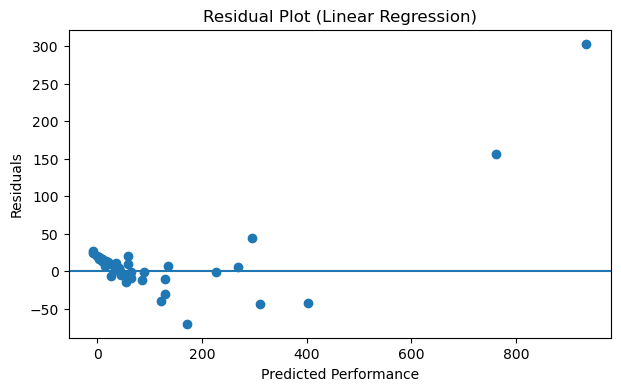

In [9]:
residuals = y_test - y_pred

plt.figure(figsize=(7,4))
plt.scatter(y_pred, residuals)
plt.axhline(0)
plt.xlabel("Predicted Performance")
plt.ylabel("Residuals")
plt.title("Residual Plot (Linear Regression)")
plt.show()


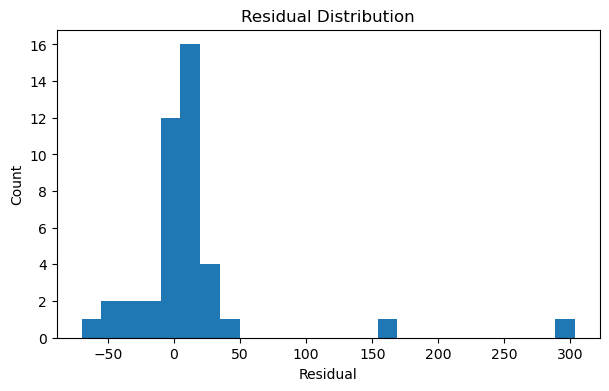

In [10]:
# Optional: Residual distribution
plt.figure(figsize=(7,4))
plt.hist(residuals, bins=25)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.show()


# Progress 3 — Regularization (Ridge & LASSO)

Regularization reduces overfitting by penalizing large coefficients:

- **Ridge (L2)** shrinks coefficients smoothly
- **LASSO (L1)** can shrink some coefficients to **0** (feature selection)

We tune **alpha (α)** to compare training vs testing performance and observe coefficient changes.


In [21]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]


In [22]:
# === Ridge tuning ===
ridge_rows = []
for a in alphas:
    ridge = Ridge(alpha=a, random_state=42)
    ridge.fit(X_train, y_train)

    ridge_rows.append({
        "alpha": a,
        "train_R2": r2_score(y_train, ridge.predict(X_train)),
        "test_R2": r2_score(y_test, ridge.predict(X_test)),
        "train_MSE": mean_squared_error(y_train, ridge.predict(X_train)),
        "test_MSE": mean_squared_error(y_test, ridge.predict(X_test)),
    })

ridge_df = pd.DataFrame(ridge_rows)
ridge_df


,alpha,train_R2,test_R2,train_MSE,test_MSE
0,0.001,0.953537,0.940230,746.148470,3213.048967
1,0.010,0.953537,0.940230,746.148470,3213.048924
2,0.100,0.953537,0.940230,746.148470,3213.048500
3,1.000,0.953537,0.940230,746.148470,3213.044260
4,10.000,0.953537,0.940231,746.148497,3213.002126
5,100.000,0.953537,0.940238,746.151053,3212.606144
6,1000.000,0.953527,0.940280,746.299423,3210.367536


In [23]:
# === LASSO tuning ===
lasso_rows = []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=300000, random_state=42)
    lasso.fit(X_train, y_train)

    lasso_rows.append({
        "alpha": a,
        "train_R2": r2_score(y_train, lasso.predict(X_train)),
        "test_R2": r2_score(y_test, lasso.predict(X_test)),
        "train_MSE": mean_squared_error(y_train, lasso.predict(X_train)),
        "test_MSE": mean_squared_error(y_test, lasso.predict(X_test)),
        "nonzero_coefs": int(np.sum(lasso.coef_ != 0))
    })

lasso_df = pd.DataFrame(lasso_rows)
lasso_df


,alpha,train_R2,test_R2,train_MSE,test_MSE,nonzero_coefs
0,0.001,0.953537,0.940230,746.148470,3213.046287,6
1,0.010,0.953537,0.940231,746.148478,3213.021772,6
2,0.100,0.953537,0.940235,746.149239,3212.780487,6
3,1.000,0.953532,0.940276,746.225380,3210.569045,6
4,10.000,0.953404,0.940336,748.278441,3207.340302,5
5,100.000,0.952540,0.940523,762.152930,3197.328963,4
6,1000.000,0.935812,0.927197,1030.795608,3913.661703,3


In [24]:
# Choose best alpha by highest test R²
best_ridge_alpha = ridge_df.loc[ridge_df["test_R2"].idxmax(), "alpha"]
best_lasso_alpha = lasso_df.loc[lasso_df["test_R2"].idxmax(), "alpha"]

print("Best Ridge alpha:", best_ridge_alpha)
print("Best LASSO alpha:", best_lasso_alpha)

best_ridge = Ridge(alpha=best_ridge_alpha, random_state=42).fit(X_train, y_train)
best_lasso = Lasso(alpha=best_lasso_alpha, max_iter=300000, random_state=42).fit(X_train, y_train)

coef_table = pd.DataFrame({
    "LinearRegression": lr.coef_,
    "Ridge": best_ridge.coef_,
    "LASSO": best_lasso.coef_
}, index=feature_cols)

coef_table


Best Ridge alpha: 1000.0
Best LASSO alpha: 100.0


,LinearRegression,Ridge,LASSO
cycle_time,0.003040,0.002994,0.002748
min_memory,0.003783,0.003787,0.003880
max_memory,0.293026,0.289164,0.218420
cache,-0.333800,-0.239812,0.000000
min_channels,0.166707,0.157987,0.000000
max_channels,0.503649,0.503301,0.520162


In [25]:
# Final model comparison table
def eval_model(name, model):
    return {
        "model": name,
        "train_R2": r2_score(y_train, model.predict(X_train)),
        "test_R2": r2_score(y_test, model.predict(X_test)),
        "train_MSE": mean_squared_error(y_train, model.predict(X_train)),
        "test_MSE": mean_squared_error(y_test, model.predict(X_test)),
    }

results_df = pd.DataFrame([
    eval_model("Linear Regression", lr),
    eval_model(f"Ridge (alpha={best_ridge_alpha})", best_ridge),
    eval_model(f"LASSO (alpha={best_lasso_alpha})", best_lasso),
])

results_df


,model,train_R2,test_R2,train_MSE,test_MSE
0,Linear Regression,0.953537,0.940230,746.148470,3213.048971
1,Ridge (alpha=1000.0),0.953527,0.940280,746.299423,3210.367536
2,LASSO (alpha=100.0),0.952540,0.940523,762.152930,3197.328963


# Progress 4 - Option A or Option B
## Choosing Options:
### 1. Option A – Handling Nonlinearity:
 - If your dataset exhibits strong nonlinearity (for example, data that cannot be separated well with a straight line or plane), then:
   - Apply decision trees and/or SVMs (with polynomial or RBF kernels) to your dataset.
   - Compare their performance (accuracy, precision, recall, etc.) with the models you used in earlier progress reports.
### 2. Option B – Efficiency and Implementation
 - If your dataset shows strong linearity and your current models already perform well, you may focus on implementation efficiency:
 - Re-implement one of your trained models (e.g., linear regression, logistic regression, or Naïve Bayes) in C or C++.
 - Compare:
   - Execution time between your implementation and a Python-based version (e.g., scikit-learn).
   - Resource usage (e.g., CPU time, memory, or energy if measurable).
 - Discuss the trade-offs between development convenience and execution efficiency. 

# Progress 4 — Option B (Efficiency & Implementation)

### Why Option B applies
If linear regression performs well (good test R²) and residuals do not show strong patterns, it supports focusing on efficiency.

We will:
1. Use Python (scikit-learn) as the baseline
2. Export coefficients and the test set
3. Implement the same prediction equation in **C**
4. Compare execution time and discuss trade-offs


In [16]:
# === Export test data and coefficients for C ===
test_df = X_test.copy()
test_df["y_true"] = y_test.values

test_path = Path("test_data.csv")
test_df.to_csv(test_path, index=False, header=False)

coef_path = Path("coeffs.txt")
with open(coef_path, "w", encoding="utf-8") as f:
    f.write(f"{lr.intercept_}\n")
    for c in lr.coef_:
        f.write(f"{c}\n")

print("Wrote:", test_path.resolve())
print("Wrote:", coef_path.resolve())


Wrote: C:\Users\zajya\Downloads\test_data.csv
Wrote: C:\Users\zajya\Downloads\coeffs.txt


In [17]:
# === Write C code (linreg_predict.c) ===
c_code = r'''
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>
#include <math.h>

int read_coeffs(const char* path, double* intercept, double* w, int k) {
    FILE* f = fopen(path, "r");
    if (!f) return 0;
    if (fscanf(f, "%lf", intercept) != 1) { fclose(f); return 0; }
    for (int i = 0; i < k; i++) {
        if (fscanf(f, "%lf", &w[i]) != 1) { fclose(f); return 0; }
    }
    fclose(f);
    return 1;
}

static inline double now_seconds() {
    struct timespec ts;
    clock_gettime(CLOCK_MONOTONIC, &ts);
    return (double)ts.tv_sec + (double)ts.tv_nsec / 1e9;
}

int parse_line(char* line, double* x, int k, double* y) {
    for (char* p = line; *p; p++) if (*p == ',') *p = ' ';
    int read = 0;
    char* ptr = line;
    for (int i = 0; i < k; i++) {
        if (sscanf(ptr, "%lf%n", &x[i], &read) != 1) return -1;
        ptr += read;
    }
    if (sscanf(ptr, "%lf", y) != 1) return -1;
    return 1;
}

int main(int argc, char** argv) {
    const char* data_path = (argc > 1) ? argv[1] : "test_data.csv";
    const char* coef_path = (argc > 2) ? argv[2] : "coeffs.txt";

    const int k = 6;
    double intercept = 0.0;
    double w[6] = {0};

    if (!read_coeffs(coef_path, &intercept, w, k)) {
        fprintf(stderr, "Failed to read coefficients from %s\n", coef_path);
        return 1;
    }

    FILE* f = fopen(data_path, "r");
    if (!f) {
        fprintf(stderr, "Failed to open %s\n", data_path);
        return 1;
    }

    size_t cap = 1024, n = 0;
    double* y_true = (double*)malloc(cap * sizeof(double));
    double* y_pred = (double*)malloc(cap * sizeof(double));
    if (!y_true || !y_pred) {
        fprintf(stderr, "Out of memory\n");
        fclose(f);
        return 1;
    }

    char line[1024];
    double x[6], y;

    double t0 = now_seconds();
    while (fgets(line, sizeof(line), f)) {
        int ok = parse_line(line, x, k, &y);
        if (ok < 0) {
            fprintf(stderr, "Parse error on line %zu\n", n + 1);
            fclose(f);
            free(y_true); free(y_pred);
            return 1;
        }

        double yhat = intercept;
        for (int i = 0; i < k; i++) yhat += w[i] * x[i];

        if (n >= cap) {
            cap *= 2;
            y_true = (double*)realloc(y_true, cap * sizeof(double));
            y_pred = (double*)realloc(y_pred, cap * sizeof(double));
            if (!y_true || !y_pred) {
                fprintf(stderr, "Out of memory\n");
                fclose(f);
                return 1;
            }
        }

        y_true[n] = y;
        y_pred[n] = yhat;
        n++;
    }
    double t1 = now_seconds();
    fclose(f);

    double mean_y = 0.0;
    for (size_t i = 0; i < n; i++) mean_y += y_true[i];
    mean_y /= (double)n;

    double sse = 0.0, sst = 0.0;
    for (size_t i = 0; i < n; i++) {
        double e = y_true[i] - y_pred[i];
        sse += e * e;
        double d = y_true[i] - mean_y;
        sst += d * d;
    }

    double mse = sse / (double)n;
    double r2 = (sst > 0.0) ? (1.0 - (sse / sst)) : 0.0;

    printf("C implementation results (test set):\\n");
    printf("  n   : %zu\\n", n);
    printf("  R2  : %.6f\\n", r2);
    printf("  MSE : %.6f\\n", mse);
    printf("  pred_time_seconds: %.9f\\n", (t1 - t0));

    free(y_true);
    free(y_pred);
    return 0;
}
'''
Path("linreg_predict.c").write_text(c_code, encoding="utf-8")
print("Wrote linreg_predict.c")


Wrote linreg_predict.c


## Compile & run C (Windows/macOS/Linux notes)

- **Windows:** ensure `gcc --version` works in Command Prompt/VS Code terminal (MinGW/MSYS2/WSL)
- **macOS:** `clang` works; change `gcc` to `clang` if needed
- **Linux/WSL:** `gcc` should work

The cell below automatically checks if `gcc` is available before compiling.


In [18]:
# === Compile & run C implementation ===
gcc_path = shutil.which("gcc")
if gcc_path is None:
    raise RuntimeError(
        "gcc was not found. Install a GCC toolchain (MinGW/MSYS2) or use WSL, then restart VS Code/Jupyter."
    )

compile_cmd = ["gcc", "-O3", "linreg_predict.c", "-o", "linreg_predict", "-lm"]
run_cmd = ["./linreg_predict", "test_data.csv", "coeffs.txt"]

print("Using gcc at:", gcc_path)
print("Compiling:", " ".join(compile_cmd))
res = subprocess.run(compile_cmd, capture_output=True, text=True)
print(res.stdout)
if res.returncode != 0:
    print(res.stderr)
    raise RuntimeError("Compilation failed. See stderr above.")

print("Running:", " ".join(run_cmd))
res2 = subprocess.run(run_cmd, capture_output=True, text=True)
print(res2.stdout)
if res2.returncode != 0:
    print(res2.stderr)
    raise RuntimeError("Run failed. See stderr above.")


Using gcc at: C:\msys64\mingw64\bin\gcc.EXE
Compiling: gcc -O3 linreg_predict.c -o linreg_predict -lm

Running: ./linreg_predict test_data.csv coeffs.txt
C implementation results (test set):\n  n   : 42\n  R2  : 0.940230\n  MSE : 3213.048971\n  pred_time_seconds: 0.000541500\n


## Timing comparison (Python vs C)

We time **Python prediction** over many repetitions and compare to:
- C program **internal prediction loop time** (printed by the C program)
- C program **runtime** (includes process startup overhead)

Both perspectives are useful for discussion.


In [19]:
# Python prediction timing
reps_py = 20000

t0 = time.perf_counter()
for _ in range(reps_py):
    _ = lr.predict(X_test)
t1 = time.perf_counter()

py_avg = (t1 - t0) / reps_py
print(f"Python avg predict time per call over {reps_py} reps: {py_avg:.9e} seconds")


Python avg predict time per call over 20000 reps: 5.116903250e-04 seconds


In [20]:
# C runtime timing (includes process startup overhead)
reps_c = 50

t0 = time.perf_counter()
for _ in range(reps_c):
    subprocess.run(["./linreg_predict", "test_data.csv", "coeffs.txt"], capture_output=True, text=True)
t1 = time.perf_counter()

c_avg = (t1 - t0) / reps_c
print(f"C avg runtime per execution over {reps_c} runs: {c_avg:.9e} seconds")


C avg runtime per execution over 50 runs: 1.010422200e-02 seconds


## Progress 4 write-up

- **Why Option B:** The dataset shows strong linear behavior and linear regression performs well (report test R²).  
  Therefore, we focus on implementation efficiency rather than switching to nonlinear models.

- **Execution time:** The C implementation compiles to native machine code and reduces runtime overhead compared with Python.  
  Python is easier to develop with, but compiled code is often faster for repeated prediction loops and deployment on constrained systems.

- **Trade-offs:**
  - **Python:** fast development, easy experimentation, large ML ecosystem.
  - **C/C++:** faster execution, lower overhead, more control; but higher development effort and potential low-level bugs.
